<a href="https://colab.research.google.com/github/jbarnesspain/multitask_negation_for_targeted_sentiment/blob/master/notebooks/Speculation_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%%capture
!pip install git+git://github.com/jbarnesspain/multitask_negation_for_targeted_sentiment.git@master#egg=multitask_negation_target

In [0]:
from typing import List, Dict
from collections import defaultdict
from pathlib import Path
import tempfile

import requests
from sklearn.metrics import accuracy_score, f1_score
from multitask_negation_target.analysis import evaluation_metrics
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rc('font', size=14)
matplotlib.rc('axes', titlesize=14)
matplotlib.rc('axes', labelsize=14)
matplotlib.rc('legend', fontsize=10)
matplotlib.rc('xtick', labelsize=12)
matplotlib.rc('ytick', labelsize=12)
sns.set_style("whitegrid")

ROW_ORDER=['Test', 'Validation']
DATASET_ORDER = ['Laptop', 'Restaurant', 'MAMS']
HUE_ORDER = ['STL', 'MTL (UPOS)', 'MTL (DR)', 'MTL (LEX)', 'MTL (CD)', 
             'MTL (SFU)', 'MTL (SPEC)']

def mean_std(data: pd.Series) -> str:
   to_percentage = data * 100
   return f'{np.mean(to_percentage):.2f} ({np.std(to_percentage):.2f})'

def create_quad_plot(data_df: pd.DataFrame) -> List[List[plt.Axes]]:
  fig, axes = plt.subplots(2,2,figsize=(15,10))
  dataset_list_order = [['Restaurant', 'MAMS'],['Laptop', 'mpqa']]
  METRIC_ORDER = ['F1-i', 'Acc-s', 'F1-s', 'F1-a']
  for row_index, dataset_name_list in enumerate(dataset_list_order):
    for col_index, dataset_name in enumerate(dataset_name_list):
      df = data_df[data_df['Dataset']==dataset_name]
      axes[row_index][col_index] = sns.pointplot(join=False, dodge=0.8, ci='sd',
                                                y='Score', hue='Model',
                                                x='Metric', data=df,
                                                hue_order=HUE_ORDER,
                                                order=METRIC_ORDER,
                                                ax=axes[row_index][col_index])
      axes[row_index][col_index].set_title(f'{dataset_name}')
      if row_index == 0:
        axes[row_index][col_index].set_xlabel('')
      if col_index == 1:
        axes[row_index][col_index].set_ylabel('')
      if row_index != 0 or col_index == 1:
        axes[row_index][col_index].get_legend().remove()
      else:
        axes[row_index][col_index].legend(ncol=7, borderaxespad=0.,
                                          bbox_to_anchor=(0.18, 1.1), 
                                          loc='lower left')
  return axes

def create_triple_plot(data_df: pd.DataFrame) -> List[plt.Axes]:
  fig, axes = plt.subplots(1,3,figsize=(22.5, 5))
  dataset_list_order = ['Restaurant', 'MAMS', 'Laptop']
  METRIC_ORDER = ['F1-i', 'Acc-s', 'F1-s', 'F1-a']
  for col_index, dataset_name in enumerate(dataset_list_order):
    df = data_df[data_df['Dataset']==dataset_name]
    axes[col_index] = sns.pointplot(join=False, dodge=0.8, ci='sd', y='Score', 
                                    hue='Model', x='Metric', data=df,
                                    hue_order=HUE_ORDER, order=METRIC_ORDER,
                                    ax=axes[col_index])
    axes[col_index].set_title(f'{dataset_name}')
    if col_index != 0:
      axes[col_index].set_ylabel('')
    if col_index != 0:
      axes[col_index].get_legend().remove()
    else:
      axes[col_index].legend(ncol=7, borderaxespad=0., 
                             bbox_to_anchor=(0.9, 1.1), loc='lower left')
  return axes

def get_speculation_data(filtered: bool) -> Dict:

  speculation_results_df_dict = defaultdict(list)

  base_url = 'https://raw.githubusercontent.com/jbarnesspain/multitask_negation_for_targeted_sentiment/master/data/results/en'
  model_names = ['STL', 'MTL (CD)', 'MTL (SFU)', 'MTL (UPOS)', 'MTL (DR)', 'MTL (LEX)', 'MTL (SPEC)']
  dataset_names = ['Laptop', 'Restaurant', 'MAMS']
  for model_name in model_names:
    if model_name == 'STL':
      model_url = base_url + '/stl'
    elif model_name == 'MTL (CD)':
      model_url = base_url + '/mtl/conan_doyle'
    elif model_name == 'MTL (SFU)':
      model_url = base_url + '/mtl/sfu'
    elif model_name == 'MTL (SPEC)':
      model_url = base_url + '/mtl/sfu_spec'
    elif model_name == 'MTL (UPOS)':
      model_url = base_url + '/mtl/u_pos'
    elif model_name == 'MTL (DR)':
      model_url = base_url + '/mtl/dr'
    elif model_name == 'MTL (LEX)':
      model_url = base_url + '/mtl/lextag'
    for dataset_name in dataset_names:
      result_url = model_url + f'/{dataset_name.lower()}/dev_spec.conll'
      if filtered:
        result_url = model_url + f'/{dataset_name.lower()}/dev_spec_only.conll'
      if dataset_name == 'MAMS':
        result_url = model_url + f'/{dataset_name}/dev_spec.conll'
        if filtered:
          result_url = model_url + f'/{dataset_name}/dev_spec_only.conll'
      for run_number in range(5):
        with tempfile.TemporaryDirectory() as temp_dir:
          temp_fp = Path(temp_dir, 'temp_file.txt')
          with temp_fp.open('w') as temp_file:
            temp_file.write(requests.get(result_url).text)
          f1_a = evaluation_metrics.span_f1(temp_fp, run_number=run_number, 
                                            ignore_sentiment=True)
          f1_a_recall, f1_a_precision, f1_a = f1_a
          f1_i = evaluation_metrics.span_f1(temp_fp, run_number=run_number, 
                                            ignore_sentiment=False)
          f1_i_recall, f1_i_precision, f1_i = f1_i
          f1_i_pos = evaluation_metrics.span_f1(temp_fp, run_number=run_number, 
                                                ignore_sentiment=False, 
                                                filter_by_sentiment='POS')
          f1_i_pos_recall, f1_i_pos_precision, f1_i_pos = f1_i_pos
          f1_i_neu = evaluation_metrics.span_f1(temp_fp, run_number=run_number, 
                                                ignore_sentiment=False, 
                                                filter_by_sentiment='NEU')
          f1_i_neu_recall, f1_i_neu_precision, f1_i_neu = f1_i_neu
          f1_i_neg = evaluation_metrics.span_f1(temp_fp, run_number=run_number, 
                                                ignore_sentiment=False, 
                                                filter_by_sentiment='NEG') 
          f1_i_neg_recall, f1_i_neg_precision, f1_i_neg = f1_i_neg
          f1_s = evaluation_metrics.span_label_metric(temp_fp, run_number=run_number, 
                                                      metric_func=f1_score, 
                                                      average='macro')
          acc_s = evaluation_metrics.span_label_metric(temp_fp, run_number=run_number,
                                                      metric_func=accuracy_score)
          speculation_results_df_dict['Model'].append(model_name)
          speculation_results_df_dict['Dataset'].append(dataset_name)
          speculation_results_df_dict['Run'].append(run_number)
          speculation_results_df_dict['F1-a'].append(f1_a)
          speculation_results_df_dict['F1-a-R'].append(f1_a_recall)
          speculation_results_df_dict['F1-a-P'].append(f1_a_precision)
          speculation_results_df_dict['F1-i'].append(f1_i)
          speculation_results_df_dict['F1-i-R'].append(f1_i_recall)
          speculation_results_df_dict['F1-i-P'].append(f1_i_precision)
          speculation_results_df_dict['F1-i-pos'].append(f1_i_pos)
          speculation_results_df_dict['F1-i-pos-R'].append(f1_i_pos_recall)
          speculation_results_df_dict['F1-i-pos-P'].append(f1_i_pos_precision)
          speculation_results_df_dict['F1-i-neg'].append(f1_i_neg)
          speculation_results_df_dict['F1-i-neg-R'].append(f1_i_neg_recall)
          speculation_results_df_dict['F1-i-neg-P'].append(f1_i_neg_precision)
          speculation_results_df_dict['F1-i-neu'].append(f1_i_neu)
          speculation_results_df_dict['F1-i-neu-R'].append(f1_i_neu_recall)
          speculation_results_df_dict['F1-i-neu-P'].append(f1_i_neu_precision)
          speculation_results_df_dict['F1-s'].append(f1_s)
          speculation_results_df_dict['Acc-s'].append(acc_s)
  return speculation_results_df_dict


# Evaluating for speculation

In this notebook we evaluate the different Targetted Sentiment Analysis (TSA) models. For more information about the models and the data see the [evaluation notebook for the main data.](https://github.com/jbarnesspain/multitask_negation_for_targeted_sentiment/blob/master/notebooks/Evaluation_Metrics.ipynb) In this notebook unlike the main data one we are only evaluating on the speculation version of the **Laptop** and **Restaurant** datasets.

The models will be compared across the following four metrics taken from [He et al. 2019](https://www.aclweb.org/anthology/P19-1048.pdf):
1. *F1-a* - F1 score of extracting the Target only ignoring the sentiment label.
2. *F1-i* - F1 score of extracting the Target and Sentiment label thus the combined/integrated task that is the TSA task.
3. *F1-s* - Macro F1 score of the sentiment labels for all correctly extracted targets.
4. *Acc-s* - Accuracy score of the sentiment labels for all correctly extracted targets.

The speculation results are in two halves. The first is on the speculative version of the datasets that still contain samples that have no speculation but overall the number of samples that contain speculation is much larger than the original, in this notebook the data will be called **Non-Filtered Speculation**. The second half only uses samples that have speculation, all the other samples are filtered out, in this notebook the data will be called **Filtered Speculation**.

## Evaluation on the Non-Filtered Speculation data

Before any of the analysis can be done the data needs to be loaded and the metrics computed and then put into a DataFrame that has the following columns:
1. Model
2. Dataset
3. Run -- There are multiple runs for each model as each run uses a different random seed
4. Metric
5. Score


In [3]:
speculation_results_df = pd.DataFrame(get_speculation_data(False))
not_metric_cols = ['Model', 'Dataset', 'Run']
metric_cols = [col_name for col_name in speculation_results_df.columns.tolist() 
               if col_name not in not_metric_cols]
speculation_results_df = pd.melt(speculation_results_df, id_vars=not_metric_cols, 
                              value_vars=metric_cols, var_name='Metric', 
                              value_name='Score')
speculation_results_df.head()

,Model,Dataset,Run,Metric,Score
0,STL,Laptop,0,F1-a,0.712743
1,STL,Laptop,1,F1-a,0.760331
2,STL,Laptop,2,F1-a,0.752599
3,STL,Laptop,3,F1-a,0.743539
4,STL,Laptop,4,F1-a,0.731405


### F1-i

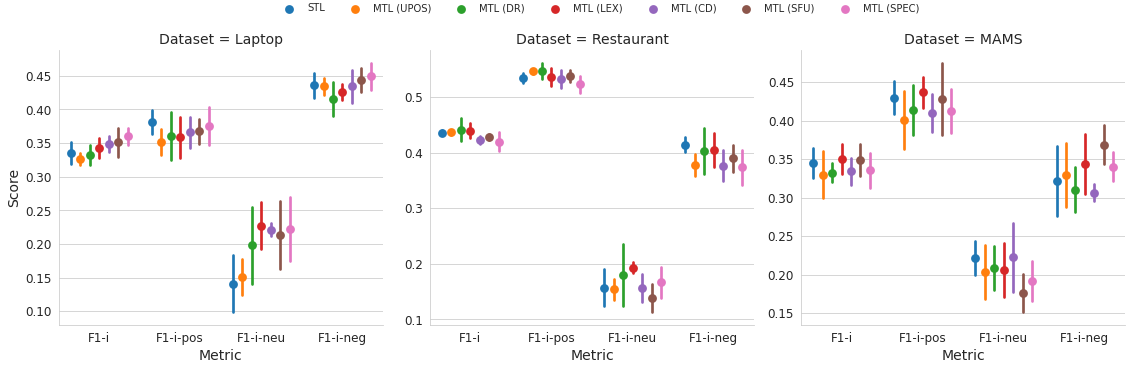

In [4]:
f1_i_order = ['F1-i', 'F1-i-pos', 'F1-i-neu', 'F1-i-neg']

f1_i_results = speculation_results_df[speculation_results_df['Metric'].isin(f1_i_order)]
ax=sns.catplot(data=f1_i_results, hue='Model', col='Dataset', x='Metric', 
               y='Score', sharex=False, sharey=False, kind='point', ci='sd', 
               join=False, dodge=0.7, row_order=ROW_ORDER, 
               hue_order=HUE_ORDER, col_order=DATASET_ORDER, 
               order=f1_i_order,
               height=5, aspect=1.1,legend=False)
_ = ax.add_legend(ncol=7, borderaxespad=0.,
                  bbox_to_anchor=(0.15, 0.98), 
                  loc='lower left')

### F1-a

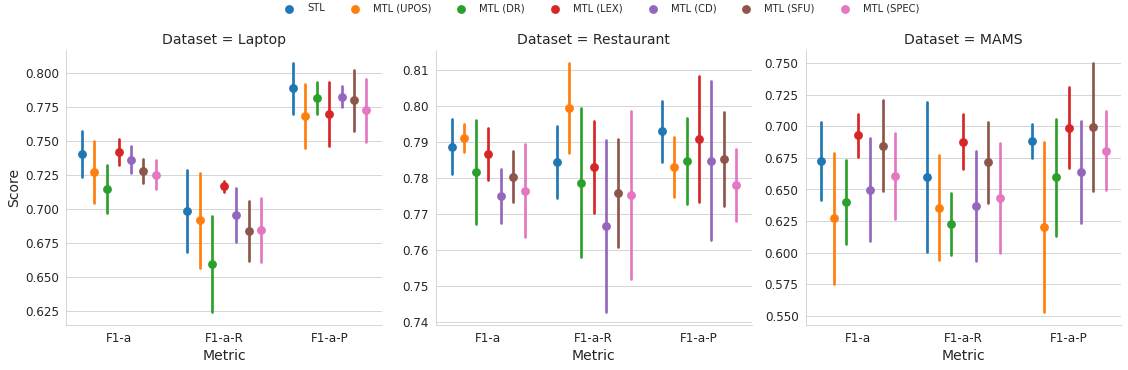

In [5]:
f1_a_order = ['F1-a', 'F1-a-R', 'F1-a-P']

f1_a_results = speculation_results_df[speculation_results_df['Metric'].isin(f1_a_order)]
ax=sns.catplot(data=f1_a_results, hue='Model', col='Dataset', x='Metric', 
               y='Score', sharex=False, sharey=False, kind='point', ci='sd', 
               join=False, dodge=0.7, row_order=ROW_ORDER, 
               hue_order=HUE_ORDER, col_order=DATASET_ORDER, 
               order=f1_a_order,
               height=5, aspect=1.1,legend=False)
_ = ax.add_legend(ncol=7, borderaxespad=0.,
                  bbox_to_anchor=(0.15, 0.98), 
                  loc='lower left')

### F1-s and Acc-s

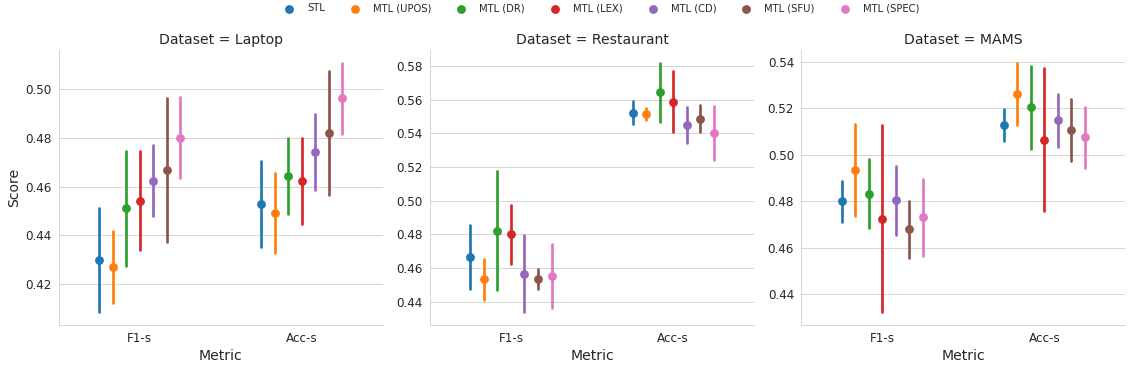

In [6]:
f1_s_order = ['F1-s', 'Acc-s']

f1_s_results = speculation_results_df[speculation_results_df['Metric'].isin(f1_s_order)]
ax=sns.catplot(data=f1_s_results, hue='Model', col='Dataset', x='Metric', 
               y='Score', sharex=False, sharey=False, kind='point', ci='sd', 
               join=False, dodge=0.5, row_order=ROW_ORDER, 
               hue_order=HUE_ORDER, col_order=DATASET_ORDER, 
               order=f1_s_order,
               height=5, aspect=1.1,legend=False)
_ = ax.add_legend(ncol=7, borderaxespad=0.,
                  bbox_to_anchor=(0.15, 0.98), 
                  loc='lower left')

### Headline Metric

These are the metrics that are shown in the paper and those that are the most important:
1. F1-I
2. F1-A
3. F1-S
4. Acc-S


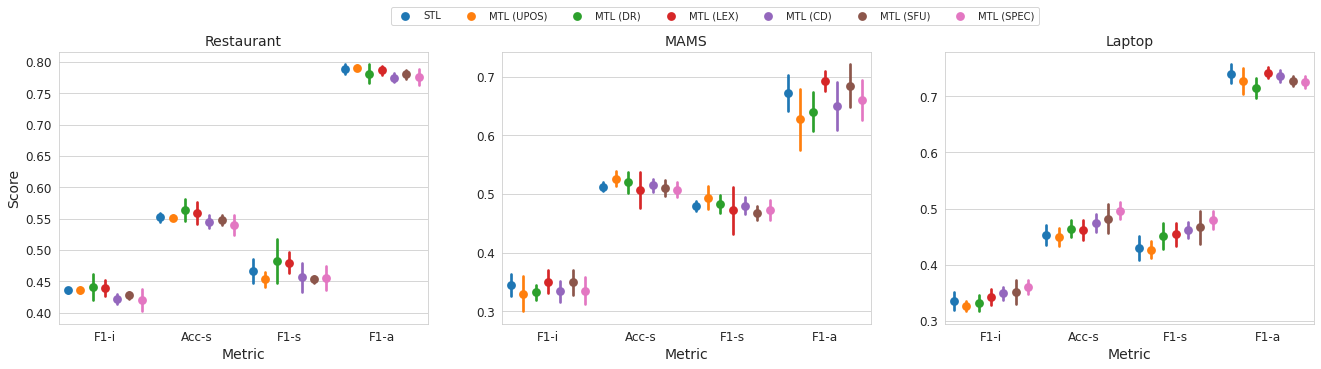

In [7]:
headline_metric_order = ['F1-i','F1-a','F1-s', 'Acc-s']
headline_results = speculation_results_df[speculation_results_df['Metric'].isin(headline_metric_order)]
_ = create_triple_plot(headline_results)

## Evaluation on the Filtered Speculation data

Before any of the analysis can be done the data needs to be loaded and the metrics computed and then put into a DataFrame that has the following columns:
1. Model
2. Dataset
3. Run -- There are multiple runs for each model as each run uses a different random seed
4. Metric
5. Score

In [8]:
speculation_results_df = pd.DataFrame(get_speculation_data(True))
not_metric_cols = ['Model', 'Dataset', 'Run']
metric_cols = [col_name for col_name in speculation_results_df.columns.tolist() 
               if col_name not in not_metric_cols]
speculation_results_df = pd.melt(speculation_results_df, id_vars=not_metric_cols, 
                              value_vars=metric_cols, var_name='Metric', 
                              value_name='Score')
speculation_results_df.head()

,Model,Dataset,Run,Metric,Score
0,STL,Laptop,0,F1-a,0.690476
1,STL,Laptop,1,F1-a,0.765152
2,STL,Laptop,2,F1-a,0.734082
3,STL,Laptop,3,F1-a,0.742647
4,STL,Laptop,4,F1-a,0.719697


F1-i

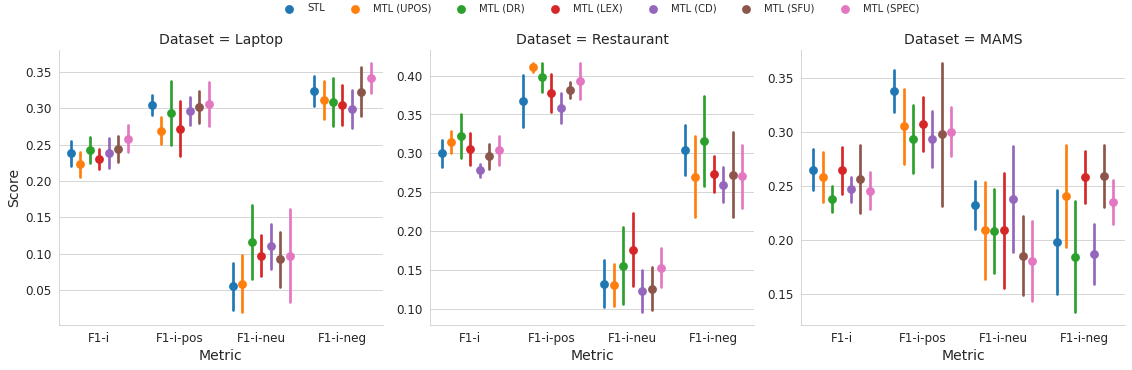

In [9]:
f1_i_order = ['F1-i', 'F1-i-pos', 'F1-i-neu', 'F1-i-neg']

f1_i_results = speculation_results_df[speculation_results_df['Metric'].isin(f1_i_order)]
ax=sns.catplot(data=f1_i_results, hue='Model', col='Dataset', x='Metric', 
               y='Score', sharex=False, sharey=False, kind='point', ci='sd', 
               join=False, dodge=0.7, row_order=ROW_ORDER, 
               hue_order=HUE_ORDER, col_order=DATASET_ORDER, 
               order=f1_i_order,
               height=5, aspect=1.1,legend=False)
_ = ax.add_legend(ncol=7, borderaxespad=0.,
                  bbox_to_anchor=(0.15, 0.98), 
                  loc='lower left')

### F1-a

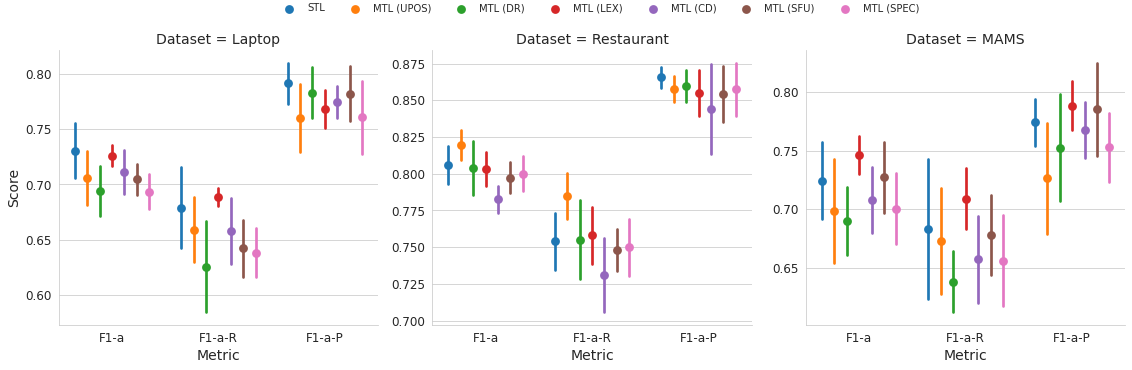

In [10]:
f1_a_order = ['F1-a', 'F1-a-R', 'F1-a-P']

f1_a_results = speculation_results_df[speculation_results_df['Metric'].isin(f1_a_order)]
ax=sns.catplot(data=f1_a_results, hue='Model', col='Dataset', x='Metric', 
               y='Score', sharex=False, sharey=False, kind='point', ci='sd', 
               join=False, dodge=0.7, row_order=ROW_ORDER, 
               hue_order=HUE_ORDER, col_order=DATASET_ORDER, 
               order=f1_a_order,
               height=5, aspect=1.1,legend=False)
_ = ax.add_legend(ncol=7, borderaxespad=0.,
                  bbox_to_anchor=(0.15, 0.98), 
                  loc='lower left')

### F1-s and Acc-s

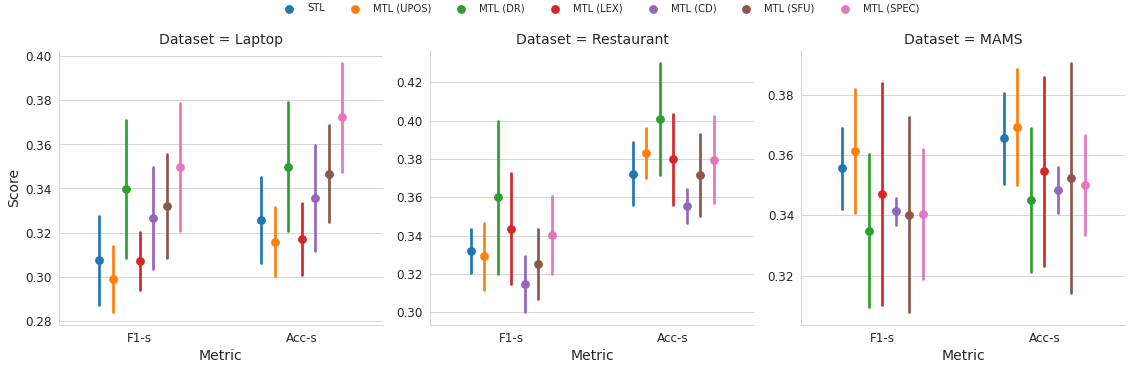

In [11]:
f1_s_order = ['F1-s', 'Acc-s']

f1_s_results = speculation_results_df[speculation_results_df['Metric'].isin(f1_s_order)]
ax=sns.catplot(data=f1_s_results, hue='Model', col='Dataset', x='Metric', 
               y='Score', sharex=False, sharey=False, kind='point', ci='sd', 
               join=False, dodge=0.5, row_order=ROW_ORDER, 
               hue_order=HUE_ORDER, col_order=DATASET_ORDER, 
               order=f1_s_order,
               height=5, aspect=1.1,legend=False)
_ = ax.add_legend(ncol=7, borderaxespad=0.,
                  bbox_to_anchor=(0.15, 0.98), 
                  loc='lower left')

### Headline Metric

These are the metrics that are shown in the paper and those that are the most important:
1. F1-I
2. F1-A
3. F1-S
4. Acc-S



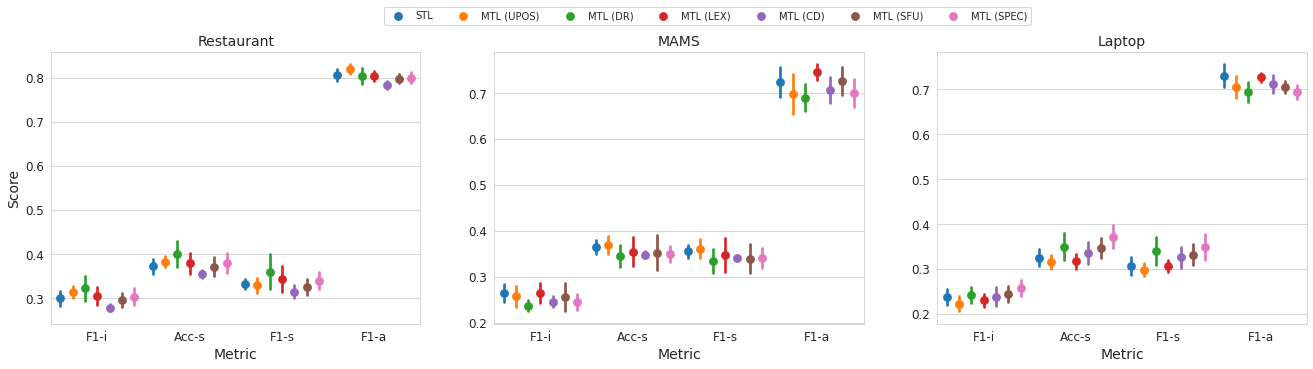

In [12]:
headline_metric_order = ['F1-i','F1-a','F1-s', 'Acc-s']
headline_results = speculation_results_df[speculation_results_df['Metric'].isin(headline_metric_order)]
_ = create_triple_plot(headline_results)